In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#having a look O_O
inspector = inspect(engine)
columns_m = inspector.get_columns('Measurement')
for column in columns_m:
    print(column["name"], column["type"])
print(f'---------------------------')    
columns_s = inspector.get_columns('Station')
for column in columns_s:
    print(column["name"], column["type"])
print(f'---------------------------')
conn = engine.connect()

m_data = pd.read_sql("SELECT * FROM measurement", conn)
m_data.tail()

# print(f'---------------------------')
# s_data = pd.read_sql("SELECT * FROM station", conn)
# s_data.head(10)


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
---------------------------


,id,station,date,prcp,tobs
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0
19549,19550,USC00516128,2017-08-23,0.45,76.0


# Exploratory Climate Analysis

The date for a year ago:  2016-08-23


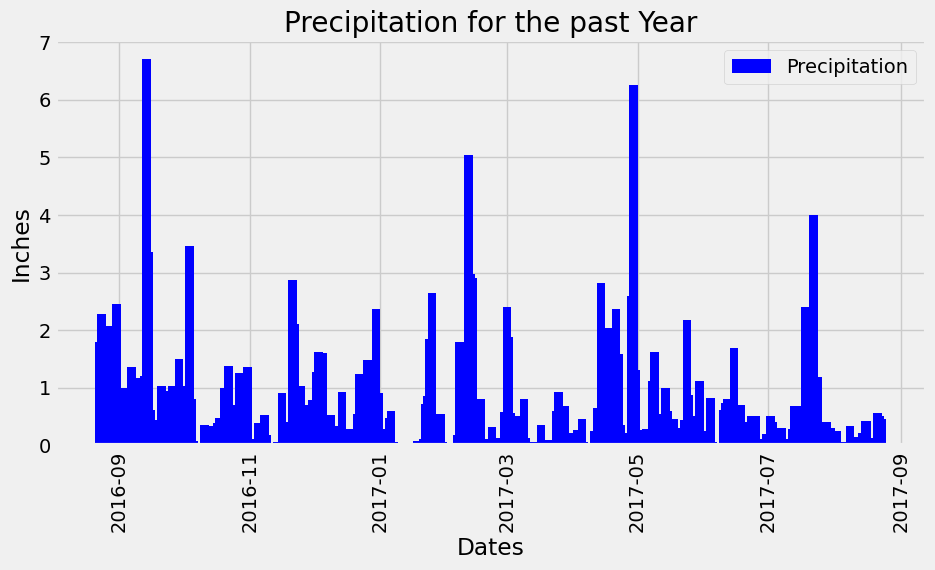

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

#from the m_data above we can see that the last date is 2017-08-23
a_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("The date for a year ago: ", a_year_ago)

#get the date range from a year ago
sel = [(Measurement.date), (Measurement.prcp)]
a_year_prcp = session.query(*sel).filter(Measurement.date >= a_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_range = pd.DataFrame(a_year_prcp, columns = ["Date", "Precipitation"])

# Sort the dataframe by date
year_range['Date'] = pd.to_datetime(year_range['Date'])
year_range = year_range.sort_values(by='Date')
year_range


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,5), dpi=100)
precip = year_range['Precipitation']
dates = year_range['Date']
plt.bar(dates, precip, color='blue', width=4)
plt.title('Precipitation for the past Year')
plt.xlabel('Dates')
plt.xticks(rotation= 90)
plt.ylabel('Inches')
plt.legend(["Precipitation"])
plt.savefig("Output/precipitation.png", bbox_inches='tight')
plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_range.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).distinct().count()
print(f'There are {station_count} stations available in this dataset')

There are 9 stations available in this dataset


In [32]:
# # What are the most active stations? (i.e. what stations have the most rows)?
count = func.count(Measurement.station)
c_query = [Measurement.station, count]

most_active_stations = session.query(*c_query).group_by(Measurement.station).\
order_by(count.desc()).all()
# List the stations and the counts in descending order.
most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mas = most_active_stations[0][0]
tobs_query = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
tobs_results = session.query(*tobs_query).filter(Measurement.station== mas).all()

print(f'Lowest Temperature Recorded for {mas}: {tobs_results[0][0]}')
print(f'Highest Temperature Recorded for {mas}: {tobs_results[0][1]}')
print(f'Average Temperature Recorded for {mas}: {round(tobs_results[0][2], 2)}')

Lowest Temperature Recorded for USC00519281: 54.0
Highest Temperature Recorded for USC00519281: 85.0
Average Temperature Recorded for USC00519281: 71.66


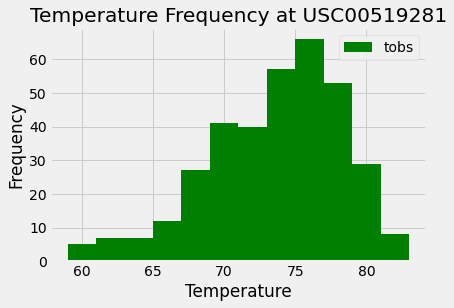

In [55]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

all_temp = session.query(Measurement.date,Measurement.tobs).filter(Measurement.station==mas).\
filter(Measurement.date >= a_year_ago).order_by(Measurement.date.desc()).all()

observed_temp = pd.DataFrame(all_temp)

observed_temp.hist(column='tobs',grid=True, bins= 12, color='green', legend=True) #bins set to 12 representing 12 months
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Frequency at {mas}')
plt.savefig("Output/temp_freq.png", bbox_inches='tight', dpi=100)


## Bonus Challenge Assignment

In [56]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [61]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2013-06-05','2013-06-20')
print(f'Lowest Temp for the period: {trip_temp[0][0]}')
print(f'Average Temp for the period: {round(trip_temp[0][1], 2)}')
print(f'Highest Temp for the period: {trip_temp[0][2]}')


Lowest Temp for the period: 68.0
Average Temp for the period: 74.91
Highest Temp for the period: 81.0


In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
